In [1]:
import numpy as np
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})
from FVSimulation_phase_density.Finite_volume_method_1D import *

In [2]:
chippath = '../DataKian/bTa_LT278W2chip5/'
lambdanm = 402
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90
KID402 = KID_data(chippath,lambdanm,filename,length)

chippath = '../DataKian/bTa_LT278W2chip5/'
lambdanm = 673
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90
KID673 = KID_data(chippath,lambdanm,filename,length)

chippath = '../DataKian/bTa_LT278W2chip5/'
lambdanm = 986
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90
KID986 = KID_data(chippath,lambdanm,filename,length)

chippath = '../DataKian/bTa_LT278W2chip5/'
lambdanm = 1545
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90
KID1545 = KID_data(chippath,lambdanm,filename,length)

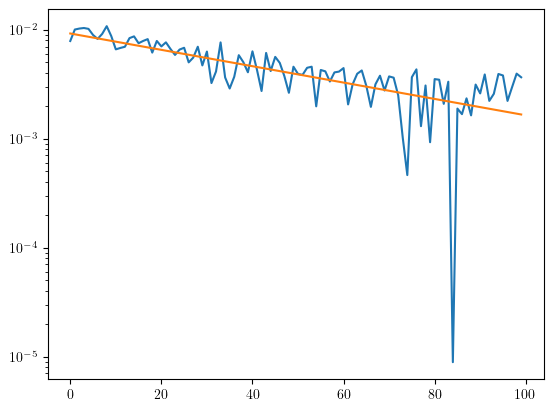

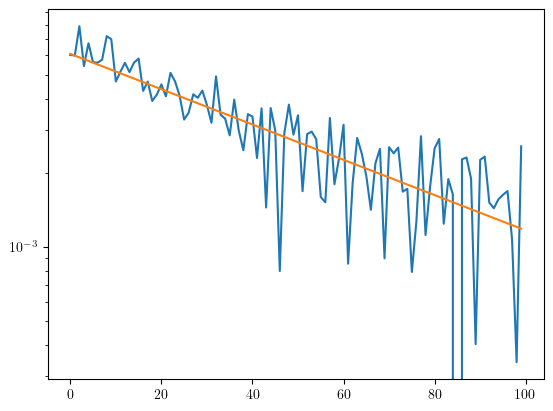

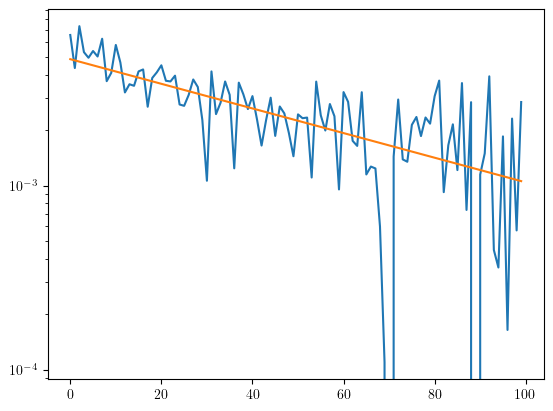

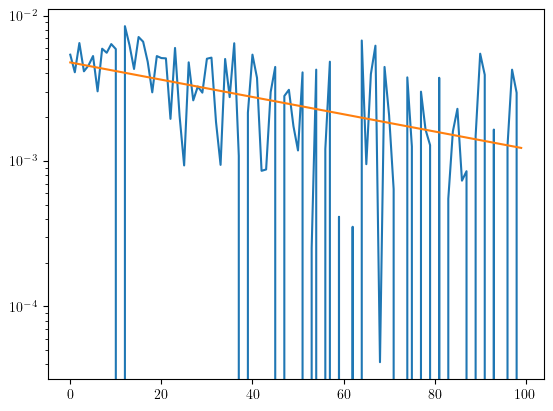

In [3]:
KID402.fit_tail(start=150,end=250)
KID673.fit_tail(start=150,end=250)
KID986.fit_tail(start=150,end=250)
KID1545.fit_tail(start=130,end=230)

In [4]:
print(KID402.tauqpstar,KID402.tauqpstarstd)
print(KID673.tauqpstar,KID673.tauqpstarstd)
print(KID986.tauqpstar,KID986.tauqpstarstd)
print(KID1545.tauqpstar,KID1545.tauqpstarstd)

L=KID402.L

KIDdict = {
    402 : KID402,
    673 : KID673,
    986 : KID986,
    1545 : KID1545
}

57.85116564901458 7.774861307818078
60.57728360757431 4.699675763299635
64.87399964454802 8.223499994421516
73.15659512565429 17.416104213370456


In [5]:
offset = 3
simtime = 100
indmin = 100 + offset
indmax = 100 + simtime-1 + offset

def func_to_parallelize(t,D,L,K,KID):
     SIM = KID_sim(KID,D,K,0.05,1/4,L=L,start_offset=offset,simtime_approx=simtime)
     return np.interp(t,SIM.t_axis,SIM.timeseriestheta)
     

def fitfunc(t,D,L,K):
     datalist = Parallel(n_jobs=4)(delayed(func_to_parallelize)(t,D,L,K,KIDdict[l]) for l in [402,673,986,1545])
     return np.concatenate(datalist)

In [6]:

fitdatax1545 = KIDdict[1545].t_full[indmin:indmax]-indmin
fitdatay1545 = KIDdict[1545].phase[indmin:indmax]
fitdatax986 = KIDdict[986].t_full[indmin:indmax]-indmin
fitdatay986 = KIDdict[986].phase[indmin:indmax]
fitdatax673 = KIDdict[673].t_full[indmin:indmax]-indmin
fitdatay673 = KIDdict[673].phase[indmin:indmax]
fitdatax402 = KIDdict[402].t_full[indmin:indmax]-indmin
fitdatay402 = KIDdict[402].phase[indmin:indmax]

fitdatax = fitdatax402
fitdatay = np.concatenate([fitdatay402,fitdatay673,fitdatay986,fitdatay1545])

popt, pcov = curve_fit(fitfunc,fitdatax,fitdatay,p0=[10,0.1,200],bounds=[0,1000])


100%|██████████| 1000/1000 [00:02<00:00, 438.59it/s]


100%|██████████| 1000/1000 [00:02<00:00, 380.05it/s]


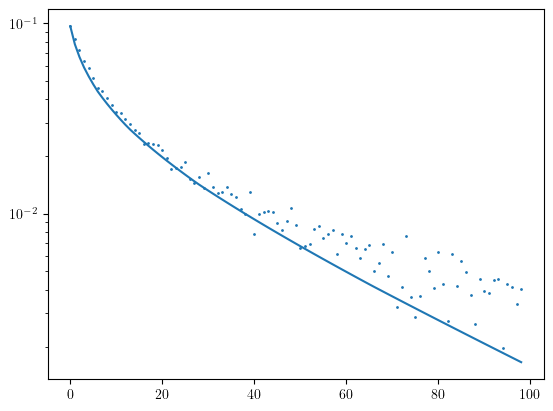

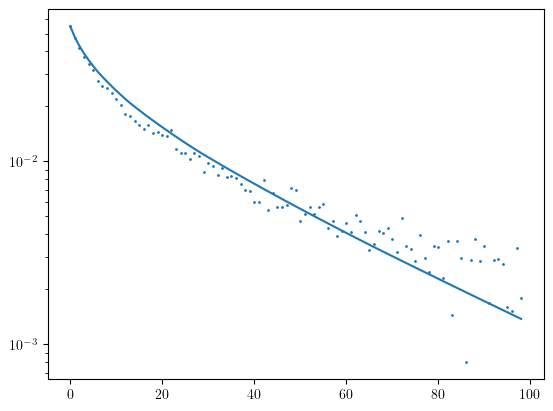

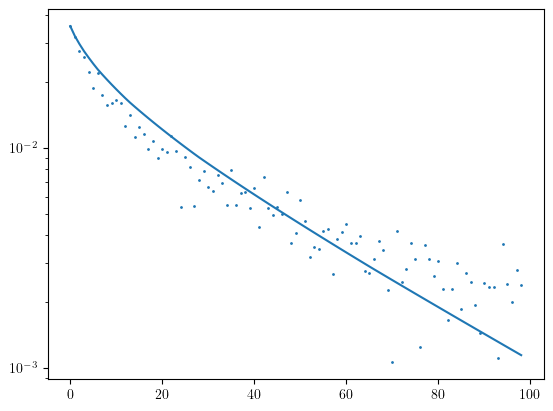

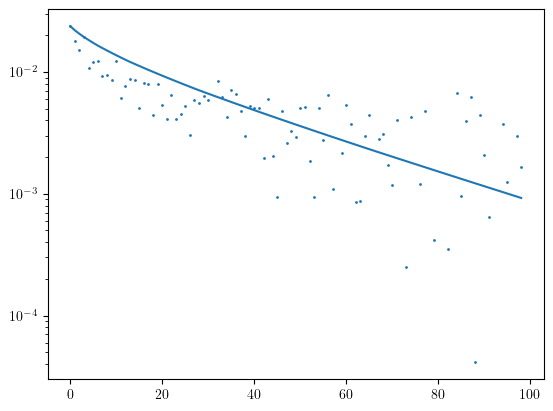

In [8]:
plotdatax = np.array([fitdatax402,fitdatax673,fitdatax986,fitdatax1545])
plotdatay = np.array([fitdatay402,fitdatay673,fitdatay986,fitdatay1545])
fitted = fitfunc(fitdatax402,popt[0],popt[1],popt[2])
plotfit = np.reshape(fitted,plotdatay.shape)
for x,y,fit in zip(plotdatax,plotdatay,plotfit):
    plt.scatter(x,y,s=1)
    plt.semilogy(x,fit)
    plt.show()

In [10]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['D','L','K']
print("Parameters:")
for i, param in enumerate(popt):
    print(f"{parameters[i]}: {param:.3f}")

print("\nStandard Deviation:")
for i, param in enumerate(np.sqrt(np.diag(pcov))):
    print(f"{parameters[i]}: {param:.3f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.3f}")

Parameters:
D: 13.969
L: 0.027
K: 162.166

Standard Deviation:
D: 7.852
L: 0.001
K: 35.045

Correlation Coefficients:
D vs L: -0.654
D vs K: 0.988
L vs K: -0.740
